# Lab 4: Non-negative Matrix Factorization

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD4"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L4_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [15]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
W \leftarrow W \circ \frac{X H^{\top}}{W (H H^{\top} + {\color{red} \nu I_r})} \\
H \leftarrow H \circ \frac{W^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(W^{\top} W + {\color{red} \mu I_r})H}
\end{array}

Fill in the following NMF class:

In [ ]:
class MYNMF():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 20                
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    D_            : np.array, W Matrix factor                | None
    S_            : np.array, H Matrix factor                | None
    D_history     : list,     W Matrix history               | []
    S_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    """
    
    def __init__(self, n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", random_state=42):
        
        self.n_components_ = n_components
        self.max_iter_     = max_iter
        self.epsilon_      = epsilon
        self.loss_         = loss
        self.D_            = None
        self.S_            = None
        self.D_history     = []
        self.S_history     = []
        self.loss_history  = []
        self.random_state  = random_state
        self.components_   = None    # shape (r, p)
        
    def fit_transform(self, data, mu=5e-3,  nu=5e-3, lambd=1e-3):
        
        """ Find the factor matrices D and S for matrix factorization of data
        
        Parameters:
        -----------                                 Default value       
        data  : (p, n) np.arrayData, matrix       | 
        mu    : float, regularization parameter   | 5e-3
        lambd : float, regularization parameter   | 1e-3
        nu    : float, regularization parameter   | 5e-3
        
        Returns:
        -----
        embedding: (p, r) np.array
                    Embedding matrix        
        """        
        np.random.seed(self.random_state)
        
        # Initialize D (W) and S (H)
        self.D_ = np.random.rand(data.shape[0], self.n_components_)  # shape (p, r)
        self.S_ = np.random.rand(self.n_components_, data.shape[1])  # shape (r, n)

        # Identity matrices for regularization
        I_r = np.eye(self.n_components_)
        ones_p_n = np.ones(data.shape)
        
        # Iterative updates
        for iteration in range(self.max_iter_):
            
            if self.loss_ == "Frobenius":
                # Frobenius updates
                self.D_ *= (data @ self.S_.T) / (self.D_ @ (self.S_ @ self.S_.T + nu * I_r) + 1e-10)
                self.S_ *= (self.D_.T @ data - lambd) / ((self.D_.T @ self.D_ + mu * I_r) @ self.S_ + 1e-10)
            elif self.loss_ == "KL":
                # KL Divergence updates
                WH = self.D_ @ self.S_
                ratio = data / (WH + 1e-10)  # Avoid division by zero
                self.D_ *= (ratio @ self.S_.T) / (ones_p_n @ self.S_.T + nu * self.D_ + 1e-10)
                self.S_ *= (self.D_.T @ ratio - lambd) / ((self.D_.T @ ones_p_n + mu) * self.S_ + 1e-10)
    
            # Calculate the regularized Frobenius loss
            WH = self.D_ @ self.S_
            if self.loss_ == "Frobenius":
                reconstruction_loss = 0.5 * np.linalg.norm(data - WH, 'fro')**2
            elif self.loss_ == "KL":
                reconstruction_loss = np.sum(data * np.log((data + 1e-10) / (WH + 1e-10)) - data + WH)
        
            regularization_loss = (0.5 * mu * np.linalg.norm(self.S_, 'fro')**2 +
                                lambd * np.sum(np.abs(self.S_)) +
                                0.5 * nu * np.linalg.norm(self.D_, 'fro')**2)
            loss = reconstruction_loss + regularization_loss

            # Store loss and history
            self.loss_history.append(loss)
            self.D_history.append(self.D_.copy())
            self.S_history.append(self.S_.copy())

            # Check for convergence
            if iteration > 0 and abs(self.loss_history[-1] - self.loss_history[-2]) < self.epsilon_:
                break

        return self.D_

    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array, data matrix
        
        Returns:
        -----
        label assignment : (p, ) np.array, Its elements are the predicted classes, from 0 to r-1
        """
        # Calculate the embedding by projecting X onto the current W (D_)
        H_pred = np.dot(self.D_.T, X)
        
        # Assign each sample to the cluster with the highest activation
        labels = np.argmax(H_pred, axis=0)
        
        return labels
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label_assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        # Calculate the embedding by projecting X onto the current W (D_)
        H_pred = np.dot(self.D_.T, X)
        
        # Normalize H_pred to get probabilities (soft assignment)
        probas = H_pred / np.sum(H_pred, axis=0, keepdims=True)
        
        return probas

## Hyperparameter optimization

### Regularization parameter : mu

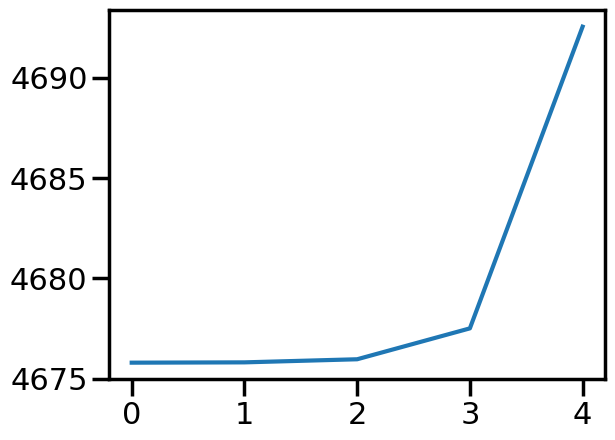

In [17]:
nmf = MYNMF()

mu_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
best_mu = None
mu_lowest_loss = float('inf')
mu_losses = []

for mu in mu_values:
    nmf.fit_transform(faces, mu=mu)

    # Evaluate the final loss for this mu
    final_loss = nmf.loss_history[-1]
    mu_losses.append(final_loss)

    # Update best mu if the current loss is lower than previous ones
    if final_loss < mu_lowest_loss:
        mu_lowest_loss = final_loss
        best_mu = mu

plt.plot(mu_losses)
plt.show()

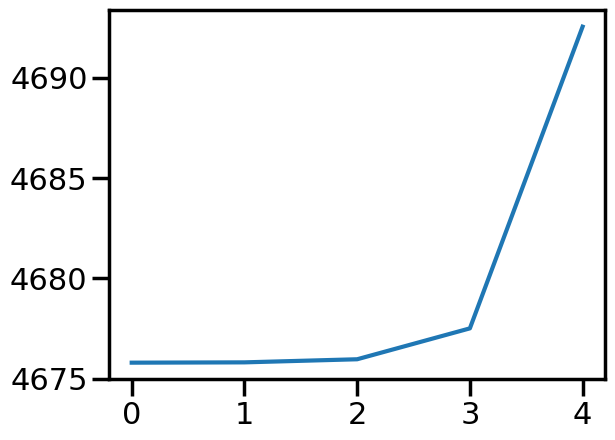

In [18]:
plt.plot(mu_losses)

### Regularization parameter : nu

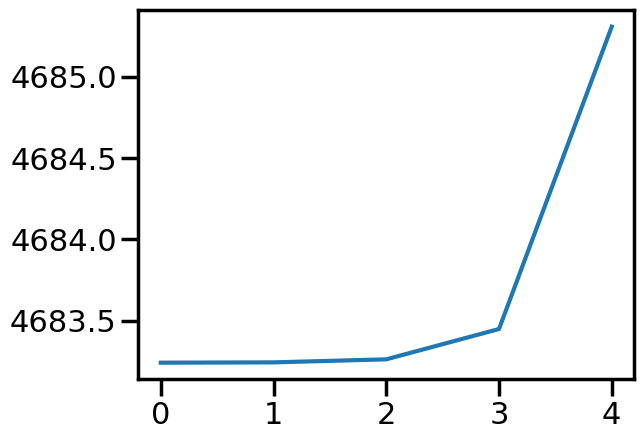

In [19]:
data = dataset["data"]

nmf = MYNMF()

nu_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
best_nu = None
nu_lowest_loss = float('inf')
nu_losses = []

for nu in nu_values:
    nmf.fit_transform(faces, nu=nu)

    # Evaluate the final loss for this mu
    final_loss = nmf.loss_history[-1]
    nu_losses.append(final_loss)

    # Update best mu if the current loss is lower than previous ones
    if final_loss < nu_lowest_loss:
        nu_lowest_loss = final_loss
        best_nu = nu

plt.plot(nu_losses)
plt.show()

### Regularization parameter : lambda

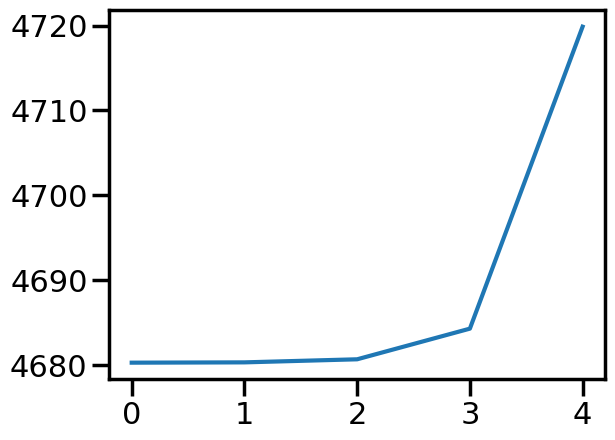

In [20]:
data = dataset["data"]

nmf = MYNMF()

lamb_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
best_lamb = None
lamb_lowest_loss = float('inf')
lamb_losses = []

for lamb in lamb_values:
    nmf.fit_transform(faces, lambd=lamb)

    # Evaluate the final loss for this mu
    final_loss = nmf.loss_history[-1]
    lamb_losses.append(final_loss)

    # Update best mu if the current loss is lower than previous ones
    if final_loss < lamb_lowest_loss:
        lamb_lowest_loss = final_loss
        best_lamb = lamb

plt.plot(lamb_losses)
plt.show()


In [21]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters

### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

In [22]:
#TODO

#### Case of Kullback-Leibler divergence

In [23]:
#TODO

## Comparison between the two distances

In [24]:
#TODO : plot the loss and normalized distances between S and D for different number of components

## Model training

### Training with Frobenius distance for different number of components

In [25]:
#TODO : Train different models for different number of components with Frobenius loss and plot loss function 

### Training with KL-divergence for different number of components

In [26]:
#TODO : Train different models for different number of components with KL divergence and plot loss function 

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

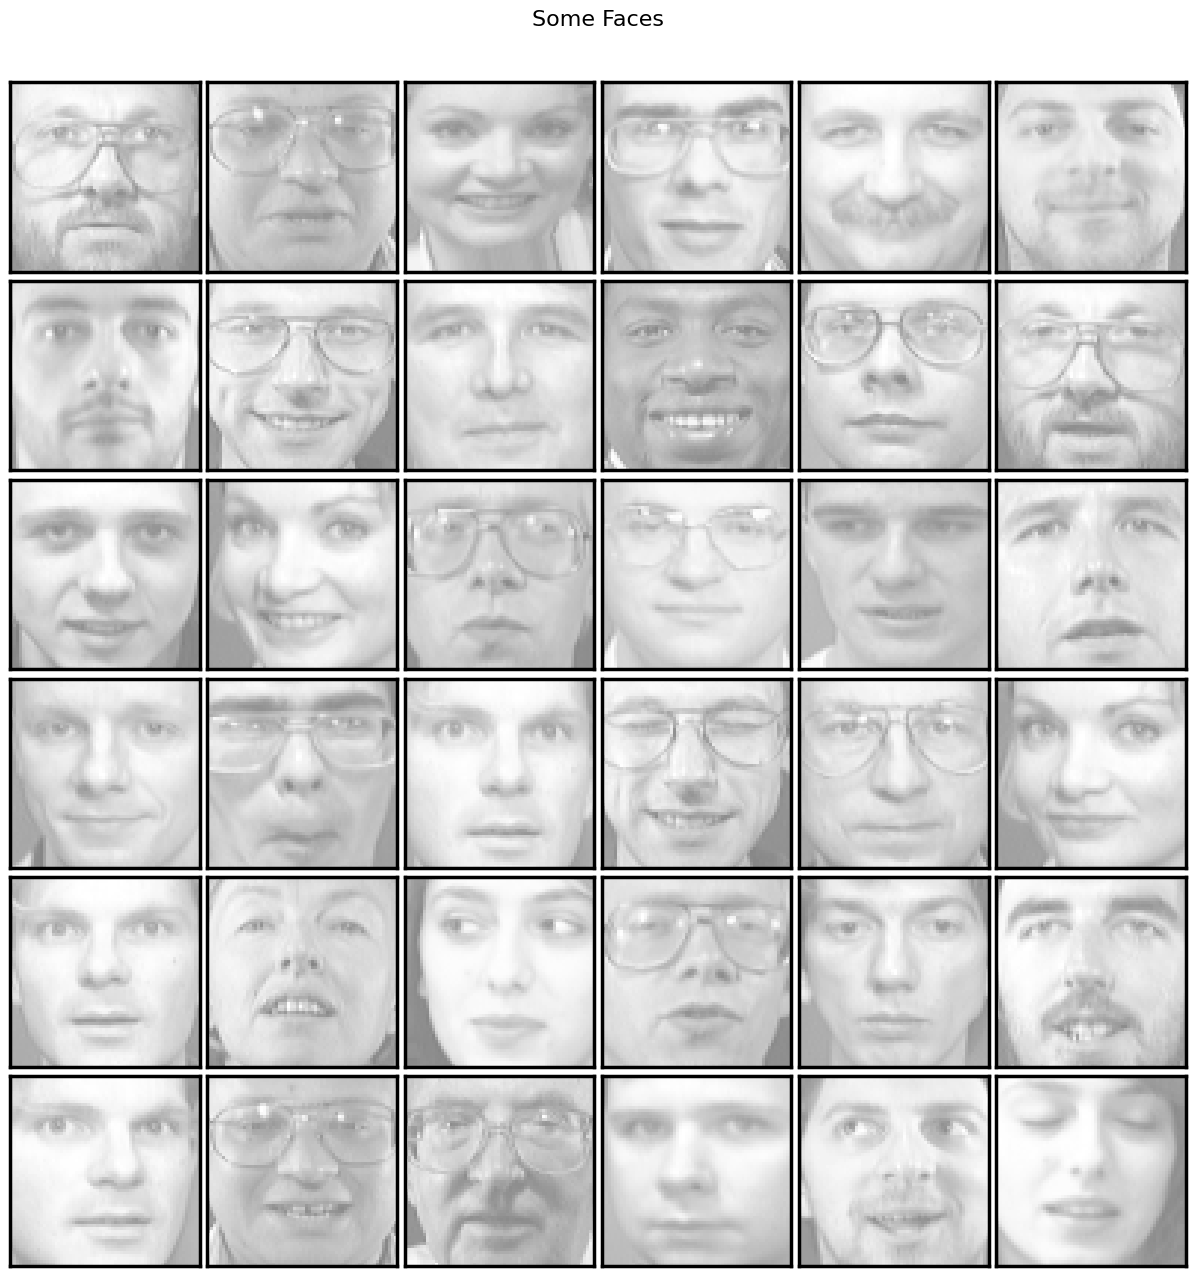

In [27]:
faces = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, nrow, ncol, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    
plot_gallery(title="Some Faces", 
             images=faces[:36], 
             image_shape=image_shape,nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

In [28]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance

#### Reconstruction with Kullback-Leibler divergence

In [29]:
#TODO : plot reconstructed faces for different number of components with KL divergence

#### Comparison of the elements of the dictionary between the two distances

In [30]:
#TODO : plot the atoms of the dictionary for various number of components

### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

In [31]:
#TODO : Study the clustering

### Second application 

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.